In [1]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, train_surrogate_tree, plot_surrogate_tree,\
                           extract_rules, print_rules, evaluate_generated_data,\
                           evaluate, plot_tree_leafs_2d, plot_diro2c_2d, get_surrogate_tree,\
                           get_feature_importances, plot_feature_importances, set_generated_data,\
                           search_max_depth_parameter
from util import RuleClassifier, evaluate_counterfactual_fidelity, get_complexity, calc_constraint_error,\
                 constraint_matrix_to_rules
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:
with open('task_with_noise.pickle', 'rb') as f:
    clf_a, clf_b, X, X_display, y, feature_names, categorical_features, feature_precisions = pickle.load(f)

In [3]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Local explanations

In [4]:
mclass_diff = comparer.predict_mclass_diff(X)

In [5]:
fidelities_to_orig = {}

## $(False, True)$

In [6]:
focus_class = '(False, True)'
focus_class_idx = list(comparer.class_names).index(focus_class)
y_true = mclass_diff == focus_class_idx

In [6]:
explainer = WrappedDiro2C(X, comparer, focus_class)

In [9]:
instance_indices = np.where(y_true)[0]

In [8]:
%%time
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.test.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/12
2/12
3/12
4/12
5/12
6/12
7/12
8/12
9/12
10/12
11/12
12/12
CPU times: user 2h 8min 56s, sys: 8min 32s, total: 2h 17min 29s
Wall time: 42min 34s


In [7]:
with open(f'diro2c.{focus_class}.test.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [8]:
with open(f'ground_truth.{focus_class}.pickle', 'rb') as f:
    ground_truth_instance_indices, ground_truth = pickle.load(f)

In [9]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

In [10]:
explanation = explanations[0]
set_generated_data(explanation, X_explain, y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


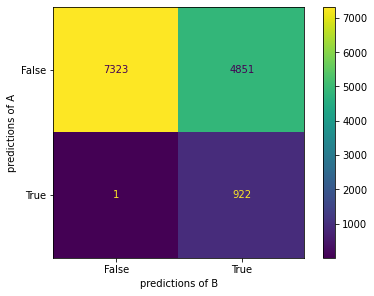

In [11]:
comparer.plot_confusion_matrix(X_explain)

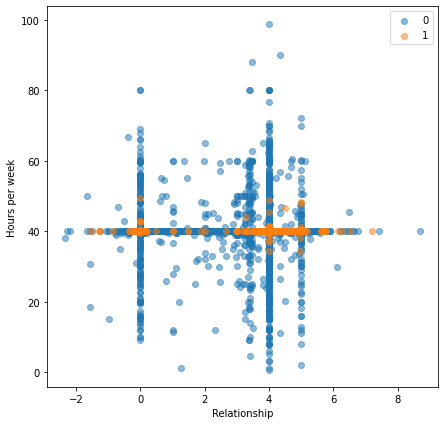

In [12]:
plot_diro2c_2d(explanation, 'Relationship', 'Hours per week')

### Find Optimal Solution

In [13]:
%%time
metrics = search_max_depth_parameter(explanation, X, y_true=y_true)

CPU times: user 20.5 s, sys: 198 ms, total: 20.7 s
Wall time: 21.4 s


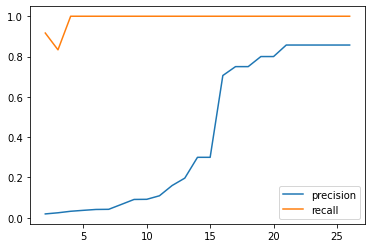

In [14]:
metrics.loc[:, ('precision', 'recall')].plot();

The closest to the original global explanations is the setting with max depth 4, because it has only 3 rules. At max depth 10, with 4 rules and 38 constraints the explanations are most similar to the original local explanations.

In [15]:
metrics[(metrics['recall'] > 0.99) & (metrics['rules'] <= 7)]

,precision,recall,rules,constraints
4,0.032258,1.0,3,12
5,0.036923,1.0,3,15
6,0.041237,1.0,3,18
7,0.041958,1.0,4,27
8,0.066298,1.0,4,30
9,0.090909,1.0,4,34
10,0.091603,1.0,4,38
11,0.109091,1.0,5,50
12,0.160000,1.0,5,53
13,0.196721,1.0,5,57


### Tree with depth 4

In [16]:
%%time
max_depth = 4
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 20.2 ms, sys: 1.91 ms, total: 22.1 ms
Wall time: 26.5 ms


In [17]:
evaluate_generated_data(explanation)

              precision    recall  f1-score   support

           0       0.94      0.81      0.87      8246
           1       0.74      0.92      0.82      4851

    accuracy                           0.85     13097
   macro avg       0.84      0.86      0.85     13097
weighted avg       0.87      0.85      0.85     13097



In [18]:
evaluate(explanation, X, y_true);

              precision    recall  f1-score   support

           0       1.00      0.63      0.77       965
           1       0.03      1.00      0.06        12

    accuracy                           0.63       977
   macro avg       0.52      0.81      0.42       977
weighted avg       0.99      0.63      0.76       977



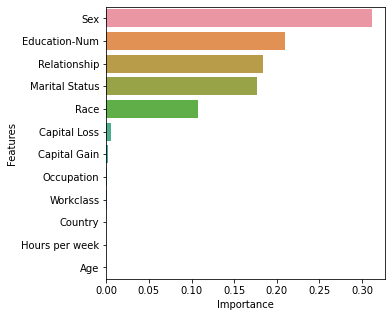

In [19]:
feature_importances, feature_order = get_feature_importances(explanation)
plot_feature_importances(explanation, feature_importances, feature_order, figsize=(5, 5))

In [20]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

3

In [21]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

64     1
70     1
406    1
484    1
531    2
558    2
701    1
744    1
883    1
925    3
948    1
961    1
dtype: int64

In [22]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [23]:
print_rules(rules, class_occurences)

1. `Marital Status` <= 2.5482282638549805 and Relationship > 3.528821349143982 and Race > 3.555514097213745 and Sex > 0.7104726135730743 [1242, 3316]
2. `Education-Num` > 13.863786697387695 and Relationship <= 3.528821349143982 and Race > 3.555514097213745 and Sex > 0.7104726135730743 [276, 753]
3. `Education-Num` > 12.505601406097412 and `Marital Status` <= 2.3837660551071167 and Relationship > 4.955262184143066 and Sex <= 0.7104726135730743 [43, 382]


#### Evaluation

##### Global Fidelity

In [24]:
evaluate(explanation, X, y_true);

              precision    recall  f1-score   support

           0       1.00      0.63      0.77       965
           1       0.03      1.00      0.06        12

    accuracy                           0.63       977
   macro avg       0.52      0.81      0.42       977
weighted avg       0.99      0.63      0.76       977



##### Counterfactual Fidelity Error

In [26]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices, ground_truth, instance_indices_per_rule, constraints)

invalid value encountered in true_divide


In [27]:
statistics

,RMSE,BMR,BAR
Age,NaN,1.000000,NaN
Workclass,NaN,1.000000,NaN
Education-Num,0.583185,0.869565,0.00
Marital Status,0.515689,0.166667,0.00
Occupation,NaN,1.000000,NaN
Relationship,1.536624,0.368421,0.00
Race,2.431983,0.083333,0.00
Sex,0.710473,0.000000,0.25
Capital Gain,NaN,1.000000,NaN
Capital Loss,NaN,1.000000,NaN


##### Complexity

In [28]:
get_complexity(constraints)

Rules           3
Constraints    12
dtype: int64

##### Stability

In [29]:
with open('explanation-diro2c-orig-01-global.pickle', 'rb') as f:
    rules_orig, constraints_orig, instance_indices_per_rule_orig = pickle.load(f)

In [30]:
indices = np.where(comparer.predict_mclass_diff(X_explain) == focus_class_idx)[0]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, rules_orig).apply(X_explain[indices]),
    RuleClassifier(feature_names, rules).apply(X_explain[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [31]:
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    3260
2     752
Name: test, dtype: int64
rule 2:
3    369
Name: test, dtype: int64


In [32]:
rule_equivalents = {1: 1, 2: 3}

In [33]:
indices = pd.Series(rule_equivalents.values()) - 1
constraints_reordered = np.array(constraints)[indices]

In [34]:
errors, statistics = calc_constraint_error(feature_names, constraints_orig, constraints_reordered)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [35]:
fidelities_to_orig[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
Age,NaN,NaN,NaN
Workclass,NaN,NaN,NaN
Education-Num,NaN,NaN,1.0
Marital Status,0.092152,0.0,0.5
Occupation,NaN,NaN,NaN
Relationship,0.189302,0.5,0.5
Race,0.011180,0.5,0.0
Sex,0.060751,0.0,0.0
Capital Gain,NaN,NaN,NaN
Capital Loss,NaN,NaN,NaN


In [36]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower  NaN        NaN            NaN             NaN         NaN   
  upper  NaN        NaN            NaN             NaN         NaN   
2 lower  NaN        NaN            NaN             NaN         NaN   
  upper  NaN        NaN            NaN       -0.092152         NaN   

         Relationship     Race       Sex  Capital Gain  Capital Loss  \
1 lower           NaN  0.01118  0.060751           NaN           NaN   
  upper           NaN      NaN       NaN           NaN           NaN   
2 lower      0.189302      NaN       NaN           NaN           NaN   
  upper           NaN      NaN  0.060751           NaN           NaN   

         Hours per week  Country  
1 lower             NaN      NaN  
  upper             NaN      NaN  
2 lower             NaN      NaN  
  upper             NaN      NaN

### Tree with depth 10

In [37]:
%%time
max_depth = 10
train_surrogate_tree(explanation, max_depth=max_depth)

CPU times: user 37.1 ms, sys: 3.71 ms, total: 40.9 ms
Wall time: 44.6 ms


In [39]:
evaluate_generated_data(explanation);

              precision    recall  f1-score   support

           0       0.97      0.94      0.96      8246
           1       0.90      0.96      0.93      4851

    accuracy                           0.94     13097
   macro avg       0.94      0.95      0.94     13097
weighted avg       0.95      0.94      0.95     13097



In [40]:
evaluate(explanation, X, y_true);

              precision    recall  f1-score   support

           0       1.00      0.84      0.91       965
           1       0.07      1.00      0.13        12

    accuracy                           0.84       977
   macro avg       0.54      0.92      0.52       977
weighted avg       0.99      0.84      0.90       977



In [41]:
y = (y_true).astype(int)
constraints, rules, class_occurences, instance_indices_per_rule = extract_rules(explanation, X, y)
len(rules)

85

In [42]:
indices = np.where(y_true)[0]
pred_rules = pd.Series(RuleClassifier(feature_names, rules).apply(X[indices]), index=indices)
pred_rules

64     1
70     2
406    1
484    1
531    3
558    3
701    1
744    1
883    2
925    4
948    1
961    1
dtype: int64

In [43]:
constraints, rules, class_occurences, instance_indices_per_rule = \
    zip(*[el for i, el in enumerate(zip(constraints, rules, class_occurences, instance_indices_per_rule), 1)
           if i in np.unique(pred_rules)])

In [44]:
print_rules(rules, class_occurences)

1. Workclass <= 5.461737632751465 and 8.961886882781982 < `Education-Num` <= 12.504138946533203 and `Marital Status` <= 2.5482282638549805 and Occupation <= 4.4321019649505615 and 3.528821349143982 < Relationship <= 4.456010818481445 and Race > 3.555514097213745 and Sex > 0.7104726135730743 and `Hours per week` > 39.59877967834473 [288, 2533]
2. Workclass <= 4.252667188644409 and `Education-Num` > 12.496589660644531 and `Marital Status` <= 2.5482282638549805 and Occupation > 4.4321019649505615 and 3.528821349143982 < Relationship <= 4.308871030807495 and Race > 3.555514097213745 and Sex > 0.7104726135730743 and `Hours per week` > 39.59877967834473 [175, 691]
3. Age > 30.821330070495605 and Workclass > 0.7596169114112854 and `Education-Num` > 13.863786697387695 and `Marital Status` <= 5.682173013687134 and Occupation > 9.571614742279053 and Relationship <= 0.7069143354892731 and Race > 3.555514097213745 and Sex > 0.7104726135730743 and `Hours per week` > 39.530757904052734 [26, 711]
4. 

#### Evaluation

##### Global Fidelity

In [45]:
evaluate(explanation, X, y_true);

              precision    recall  f1-score   support

           0       1.00      0.84      0.91       965
           1       0.07      1.00      0.13        12

    accuracy                           0.84       977
   macro avg       0.54      0.92      0.52       977
weighted avg       0.99      0.84      0.90       977



##### Counterfactual Fidelity Error

In [46]:
errors, statistics = evaluate_counterfactual_fidelity(comparer, ground_truth_instance_indices,
                                                      ground_truth, instance_indices_per_rule,
                                                      constraints)

invalid value encountered in true_divide


In [47]:
statistics

,RMSE,BMR,BAR
Age,4.846295,0.833333,0.000000
Workclass,0.516450,0.500000,0.090909
Education-Num,1.239839,0.173913,0.000000
Marital Status,0.546967,0.000000,0.000000
Occupation,1.576440,0.434783,0.000000
Relationship,0.545768,0.000000,0.095238
Race,2.431983,0.083333,0.000000
Sex,0.710473,0.000000,0.250000
Capital Gain,8349.410156,0.923077,0.000000
Capital Loss,NaN,1.000000,NaN


##### Complexity

In [48]:
get_complexity(constraints)

Rules           4
Constraints    38
dtype: int64

##### Stability

In [49]:
with open('explanation-diro2c-orig-01-local.pickle', 'rb') as f:
    rules_orig, constraints_orig, instance_indices_per_rule_orig = pickle.load(f)

In [50]:
indices = np.where(comparer.predict_mclass_diff(X_explain) == focus_class_idx)[0]
mapping_data = pd.DataFrame(columns=indices, index=['original', 'test'], data=[
    RuleClassifier(feature_names, rules_orig).apply(X_explain[indices]),
    RuleClassifier(feature_names, rules).apply(X_explain[indices])]).T
mask = ~np.any(mapping_data == 0, 1)
mapping_data = mapping_data[mask]

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


In [51]:
for orig_rule_id in np.unique(mapping_data['original']):
    print(f'rule {int(orig_rule_id)}:')
    print(mapping_data.loc[mapping_data['original'] == orig_rule_id, 'test'].value_counts())

rule 1:
1    2472
Name: test, dtype: int64
rule 2:
2    688
Name: test, dtype: int64
rule 3:
3    697
Name: test, dtype: int64
rule 4:
4    342
Name: test, dtype: int64


In [52]:
rule_equivalents = {1: 1, 2: 2, 3: 3, 4: 4}

In [53]:
indices = pd.Series(rule_equivalents.values()) - 1
constraints_reordered = np.array(constraints)[indices]

In [54]:
errors, statistics = calc_constraint_error(feature_names, constraints_orig, constraints_reordered)

invalid value encountered in true_divide
invalid value encountered in true_divide


In [55]:
fidelities_to_orig[(max_depth, focus_class)] = statistics
statistics

,RMSE,BMR,BAR
Age,3.754352,0.400000,0.000000
Workclass,0.671467,0.333333,0.333333
Education-Num,0.173858,0.000000,0.000000
Marital Status,0.110625,0.000000,0.000000
Occupation,0.623662,0.000000,0.200000
Relationship,0.171014,0.000000,0.000000
Race,0.011180,0.250000,0.000000
Sex,0.060751,0.000000,0.000000
Capital Gain,5421.659180,0.000000,0.000000
Capital Loss,NaN,NaN,NaN


In [56]:
errors

Age  Workclass  Education-Num  Marital Status  Occupation  \
1 lower       NaN        NaN       0.272923             NaN         NaN   
  upper       NaN   0.312294      -0.029077        0.043374    0.114958   
2 lower       NaN        NaN      -0.005412             NaN    0.114958   
  upper       NaN  -0.896776            NaN        0.043374         NaN   
3 lower -6.283452        NaN      -0.064347             NaN    0.078704   
  upper       NaN        NaN            NaN       -0.191564         NaN   
4 lower -0.117832        NaN       0.267640             NaN    1.234176   
  upper -1.670279        NaN            NaN       -0.092152         NaN   

         Relationship     Race       Sex  Capital Gain  Capital Loss  \
1 lower     -0.209221  0.01118  0.060751           NaN           NaN   
  upper      0.053239      NaN       NaN           NaN           NaN   
2 lower     -0.209221  0.01118  0.060751           NaN           NaN   
  upper     -0.093901      NaN       NaN           NaN           NaN   
3 lower           NaN  0.01118  0.060751           NaN           NaN   
  upper      0.201099      NaN       NaN           NaN           NaN   
4 lower      0.189302      NaN       NaN           NaN           NaN   
  upper           NaN      NaN  0.060751    5421.65918           NaN   

         Hours per week  Country  
1 lower       -0.079355      NaN  
  upper             NaN      NaN  
2 lower       -0.079355      NaN  
  upper             NaN      NaN  
3 lower       -0.147377      NaN  
  upper             NaN      NaN  
4 lower        0.107044      NaN  
  upper             NaN      NaN

It missed the upper boundaries of Hours per week.

# Summary

In [58]:
def map_index(index):
    class_, depth = index[0], index[1]
    if depth == 4:
        level = 'global'
    elif depth == 10:
        level = 'local'
    else:
        level = None
    return (class_, level) if len(index) == 2 else (class_, level, index[2])

## Stability

In [59]:
fidelity_to_orig = pd.concat(fidelities_to_orig.values(), keys=fidelities_to_orig.keys(), names=('depth', 'class', 'feature'))
fidelity_to_orig = fidelity_to_orig.reorder_levels(['class', 'depth', 'feature']).sort_index()
fidelity_to_orig

RMSE       BMR       BAR
class         depth feature                                        
(False, True) 4     Age                     NaN       NaN       NaN
                    Capital Gain            NaN       NaN       NaN
                    Capital Loss            NaN       NaN       NaN
                    Country                 NaN       NaN       NaN
                    Education-Num           NaN       NaN  1.000000
                    Hours per week          NaN  1.000000       NaN
                    Marital Status     0.092152  0.000000  0.500000
                    Occupation              NaN       NaN       NaN
                    Race               0.011180  0.500000  0.000000
                    Relationship       0.189302  0.500000  0.500000
                    Sex                0.060751  0.000000  0.000000
                    Workclass               NaN       NaN       NaN
              10    Age                3.754352  0.400000  0.000000
                    Capital Gain    5421.659180  0.000000  0.000000
                    Capital Loss            NaN       NaN       NaN
                    Country                 NaN  1.000000       NaN
                    Education-Num      0.173858  0.000000  0.000000
                    Hours per week     0.106973  0.500000  0.000000
                    Marital Status     0.110625  0.000000  0.000000
                    Occupation         0.623662  0.000000  0.200000
                    Race               0.011180  0.250000  0.000000
                    Relationship       0.171014  0.000000  0.000000
                    Sex                0.060751  0.000000  0.000000
                    Workclass          0.671467  0.333333  0.333333

In [60]:
fidelity_to_orig.index = fidelity_to_orig.index.map(map_index)
fidelity_to_orig = fidelity_to_orig[fidelity_to_orig.index.get_level_values('depth').notnull()]
fidelity_to_orig.index.rename(['class', 'level', 'feature'], inplace=True)

with open('results.soa.test.pickle', 'wb') as f:
    pickle.dump(fidelity_to_orig, f)